In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict,Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

### Web search tool

In [5]:
from duckduckgo_search import DDGS
# import ddgs

# results = DDGS().text("python programming", max_results=5)
# print(results)


@tool
def web_search(query: str, num_results:int = 10) -> str:
    """
    Use this tool whenever you need to access realtime or latest information.
    Search the web using DuckDuckGo.

    Args:
        query: Search query string
        num_results: Number of results to return (default: 5)
    
    Returns:
        Formatted search results with titles, descriptions, and URLs
    """
    results = DDGS().text(query, max_results=num_results, region = 'us-en')

    if not results:
        return f"No results found for '{query}'"

    formatted_results = [f"Search results for search query: '{query}' "]
    for i, results in enumerate(results, 1):
        title = results.get('title', 'No Title')
        href = results.get('href', 'No URL')
        body = results.get('body', 'No Description available')
        text = f"{i}. **{title}**\n  {body}\n  {href}"
        formatted_results.append(text)
    
    return "\n\n".join(formatted_results)

In [6]:
result = web_search.invoke({'query': 'Python Tutorial', 'num_results': 3})
print(result)

/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')


Search results for search query: 'Python Tutorial' 

1. **Best online resource to learn Python? - Stack Overflow**
  Mar 8, 2012 · The Python tutorial is actually pretty good. There's also a video series on showmedo about python. Between those two resources, you should have more than enough to learn the …
  https://stackoverflow.com/questions/70577/best-online-resource-to-learn-python

2. **Bloomberg API for python tutorial - Stack Overflow**
  Aug 9, 2023 · Does anyone know any good resources/ tutorials/ books to get started with Bloomberg's API blpapi in python? I have searched everywhere and I haven't found anything at all.
  https://stackoverflow.com/questions/48411386/bloomberg-api-for-python-tutorial

3. **How to build a python bot for Teams? How to deploy it in my …**
  Feb 18, 2020 · 17 I want to build a bot in Python. I would want to do various REST calls using that bot. Can this be done in Teams and deployed in a production Linux server? I have a Python bot …
  https://stacko

### Agent State

In [23]:
class AgentState(TypedDict):
    messages : Annotated[list, operator.add]
    research: str
    critique: str
    iterations: int
    

### Researcher Node

In [30]:
def researcher_node(state: AgentState):
    llm_with_tools = llm.bind_tools([web_search])
    critique = state.get('critique', '')
    iterations = state.get('iterations', 0)
    
    feedback_prompt=""
    if critique:
        feedback_prompt = f"""
            Previous critique: {critique}
            Address the missing points with new sarch queries.
            """
    system_prompt = SystemMessage(f"""
        You are a research agent with web search capabilities.
        {feedback_prompt}
        INSTRUCTIONS:
        1. **MUST use web_search tool** first to gather information
        2. Provide comprehensive research based on search results

        Always call **web_search** before responding.
    """)

    messages = [system_prompt] + state['messages']

    response = llm_with_tools.invoke(messages)
    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[RESEACHER] called Tool: {tc.get('name','?')} with args: {tc.get('args','?')}")
    else:
        print(f"[RESEACHER] Responding with iteration number: {iterations+1}")
    
    return {"messages": [response]}

### Critique Node

In [31]:
def critique_node(state: AgentState):

    messages =state['messages'] 
    iterations = state['iterations']

    research_content = messages[-1].content

    system_prompt = SystemMessage("""
        You are a critique agent. Evaluate if research is good enough.
        
        Check:
        1. Does it answer the main question?
        2. Is there reasonable detail?
        
        Response Format:
        DECISION: APPROVE or REVISE
        
        Be lenient. APPROVE if research is decent enough.
        Only REVISE if critical information is completely missing.
    """)

    critique_prompt = HumanMessage(f"""
                                Evaluate this research:
                                {research_content}                                   
                                """)
    messages = [system_prompt, critique_prompt]
    response = llm.invoke(messages)

    print(f"[CRITIQUE] Iteration {iterations+1}")

    return {"critique": response.content,
            'research': research_content,
            'iteration': iterations + 1
            }

### Routing Logic

In [36]:
def should_continue(state: AgentState):
    last = state['messages'][-1]

    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    else:
        return "critique"

In [37]:
MAX_ITERATIONS = 10
def check_approval(state: AgentState):
    critique = state.get('critique',"")
    iterations = state.get("iterations",0)

    if iterations >=MAX_ITERATIONS:
        print(f"""[SYSTEM] Max iterations ({MAX_ITERATIONS}) reached. Stopping ...""")
        return END
    
    if "APPROVE" in critique.upper():
        print(f"[SYSTEM] Research approved after {iterations} iterations.")
        return END
    else:
        print(f"[SYSTEM] Revision needed. Continuing Iteration {iterations+1}")
        return "researcher"

### Build Graph

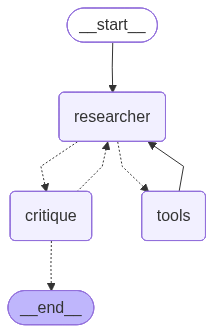

In [38]:
def create_agent():
    builder = StateGraph(AgentState)

    #add nodes
    builder.add_node('researcher',researcher_node)
    builder.add_node('critique', critique_node)
    builder.add_node('tools', ToolNode([web_search]))

    # add edges
    builder.add_edge(START, 'researcher')
    builder.add_conditional_edges('researcher', should_continue, ['tools','critique'])
    builder.add_edge('tools', 'researcher')
    builder.add_conditional_edges('critique',check_approval,['researcher', END])

    graph = builder.compile()
    return graph

agent = create_agent()
agent

### Run Agent

In [41]:
query ="What are the latest developments in Langgraph for building AI agents?"

# state = {
#     'messages':[HumanMessage(query)],
# }

result = agent.invoke({'messages': [HumanMessage(query)], 'iterations':0})

print(result['research'])


[RESEACHER] called Tool: web_search with args: {'num_results': 5, 'query': 'latest developments in Langgraph for building AI agents'}


/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')


[RESEACHER] called Tool: web_search with args: {'num_results': 5, 'query': 'LangChain latest developments'}


/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')


[RESEACHER] Responding with iteration number: 1
[CRITIQUE] Iteration 1
[SYSTEM] Research approved after 0 iterations.
<think>
Okay, the user initially asked about "Langgraph," but the search didn't return results. Then, I tried searching for "LangChain latest developments" and found several results. Now, I need to address the user's original query but clarify the possible confusion between Langgraph and LangChain.

First, I should mention that there were no results for Langgraph, so I adjusted the search to LangChain. Then, I need to summarize the findings from the LangChain search results. The key points from the results include LangChain's modules, user experiences, learning resources, and comparisons with other frameworks like spring-ai and fastgpt.

I should structure the response to first acknowledge the confusion, then provide information on LangChain's latest developments. Highlight the main modules, user feedback, and alternatives. Also, note that if the user meant a different 

In [40]:
query ="What is the latest stock price outlook for Tesla and Apple?"

result = agent.invoke({'messages': [HumanMessage(query)], 'iterations':0})

print(result['research'])


[RESEACHER] called Tool: web_search with args: {'num_results': 5, 'query': 'Tesla stock price outlook 2023'}
[RESEACHER] called Tool: web_search with args: {'num_results': 5, 'query': 'Apple stock price outlook 2023'}


/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')
/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')


[RESEACHER] called Tool: web_search with args: {'num_results': 5, 'query': 'Apple stock price forecast 2024'}


/var/folders/14/997y_1sx7mgg_cnwgfmn62m80000gn/T/ipykernel_88302/3365755738.py:21: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  results = DDGS().text(query, max_results=num_results, region = 'us-en')


[RESEACHER] Responding with iteration number: 1
[CRITIQUE] Iteration 1
[SYSTEM] Research approved after 0 iterations.
<think>
Okay, the user asked about the latest stock price outlook for Tesla and Apple. I first searched for Tesla and found some results, but when I tried Apple, there were no results. Then I adjusted the query to include 2024 and got results, but they seem to be about Apple's products and a recent AI deal, not stock forecasts.

Hmm, maybe the search terms need refinement. Let me try different keywords like "Apple stock forecast 2024" or "Apple stock analyst predictions". Also, checking financial news sites like Bloomberg or Reuters might help. Wait, the user might need both companies' outlooks, so I should ensure the search includes both names and the correct time frame. Let me try one more search with adjusted terms.
</think>

The search results for "Apple stock price forecast 2024" primarily include general information about Apple's products, services, and recent bus